# Concrete Crack Detection using CNN

This guide provides a complete Python implementation for detecting concrete cracks using the SDNET2018 dataset. This dataset contains over 56,000 images of cracked and non-cracked concrete surfaces (bridges, walls, and pavements).

It uses TensorFlow/Keras for the model and Matplotlib for all visual diagnostics.

### Installing requirements

In [8]:
# Comment out if not needed
#%pip install -r requirements.txt

### Importing and also supressing warnings

In [9]:
import os
import zipfile
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tqdm import tqdm


import warnings

# 1. Suppress TensorFlow C++ level logs (1=INFO, 2=WARN, 3=ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# 2. Suppress Python warnings (like DeprecationWarning, Matplotlib warnings)
warnings.filterwarnings('ignore')

import tensorflow as tf

# 3. Suppress TensorFlow Python-level warnings
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

print("✅ All non-critical warnings suppressed. Notebook is in 'Quiet Mode'.")


✅ All non-critical warnings suppressed. Notebook is in 'Quiet Mode'.


### Making code Hardware-Aware

Can run on lightweight CPU or powerful GPU enabled machines

In [10]:
# --- Memory Safety Logic ---
# Limit VRAM if GPU is present; otherwise, configure for low-RAM CPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU detected and configured.")
else:
    # Limit number of threads to prevent CPU spikes
    tf.config.threading.set_intra_op_parallelism_threads(2)
    tf.config.threading.set_inter_op_parallelism_threads(2)
    print("Running in Lightweight CPU Mode.")

# Dataset Constants (Reduced for RAM safety)
IMAGE_SIZE = (64, 64) 
BATCH_SIZE = 16 
SHUFFLE_BUFFER = 200 # Small buffer to prevent RAM overflow

Running in Lightweight CPU Mode.


### The SDNET2018 dataset is organized into subfolders (Bridge, Deck, Pavement, Wall). 
Within each, there are folders for "Cracked" (C) and "Uncracked" (U),  load these into a TensorFlow Dataset object.

In [11]:
dataset_url = "https://digitalcommons.usu.edu/cgi/viewcontent.cgi?filename=2&article=1047&context=all_datasets&type=additional"
zip_path = "SDNET2018.zip"
extract_path = "SDNET2018_Data"

def download_file(url, filename):
    if not os.path.exists(filename):
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        with tqdm(total=total_size, unit='iB', unit_scale=True) as pbar:
            with open(filename, 'wb') as f:
                for data in response.iter_content(1024):
                    pbar.update(len(data))
                    f.write(data)

download_file(dataset_url, zip_path)

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

### Preprocessing 
1. Load the raw dataset first
2. Save the Class Names
3. Apply the RAM-safe optimizations to the raw datasets

In [12]:
# 1. Load the raw dataset first
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    extract_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(64, 64),
    batch_size=16
)

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    extract_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(64, 64),
    batch_size=16
)

# 2. SAVE THE CLASS NAMES NOW (Crucial Step)
class_names = raw_train_ds.class_names
print(f"Successfully saved classes: {class_names}")

# 3. Apply the RAM-safe optimizations to the raw datasets
# This creates the _PrefetchDataset objects which do NOT have .class_names
train_ds = raw_train_ds.shuffle(200).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = raw_val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 56092 files belonging to 3 classes.
Using 44874 files for training.
Found 56092 files belonging to 3 classes.
Using 11218 files for validation.
Successfully saved classes: ['D', 'P', 'W']


### CNN Architecture

This code defines a Convolutional Neural Network (CNN) using TensorFlow/Keras. It is designed to take in small color images ($64 \times 64$ pixels) and classify them into different categories.


In [13]:
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(64, 64, 3)),
    # Reduced filters from 32/64/128 down to 16/32 to save RAM
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │       230,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,619 (920.39 KB)

 Trainable params: 235,619 (920.39 KB)

 Non-trainable params: 0 (0.00 B)

### Model Training and Performance Visualization

Train the model and then plot the training/validation accuracy and loss curves.

In [14]:
# Using 3 epochs for a lightweight run
EPOCHS = 3 # Use higher number if you have powerful system and need better results
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/3
2805/2805 ━━━━━━━━━━━━━━━━━━━━ 105s 37ms/step - accuracy: 0.6560 - loss: 0.6685 - val_accuracy: 0.7185 - val_loss: 0.6141
Epoch 2/3
2805/2805 ━━━━━━━━━━━━━━━━━━━━ 145s 38ms/step - accuracy: 0.7273 - loss: 0.5534 - val_accuracy: 0.7121 - val_loss: 0.5745
Epoch 3/3
2805/2805 ━━━━━━━━━━━━━━━━━━━━ 102s 36ms/step - accuracy: 0.8070 - loss: 0.4559 - val_accuracy: 0.8480 - val_loss: 0.3839


### Visualization 1: Training Metrics

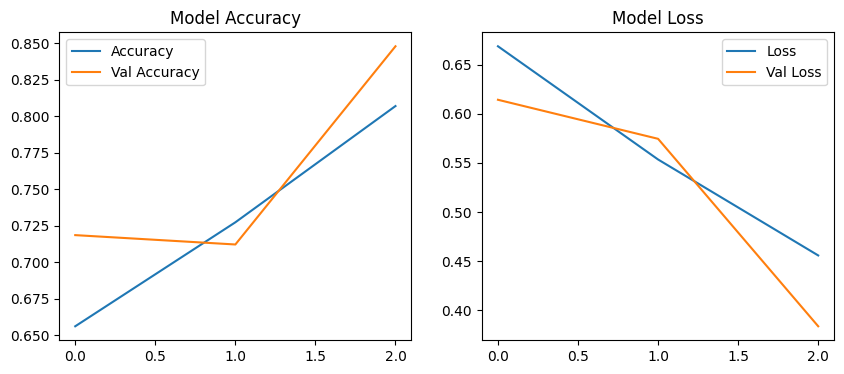

In [15]:
# --- Visualization 1: Training Metrics ---
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

### Visualization 2: Classification Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


2025-12-18 05:07:02.911565: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


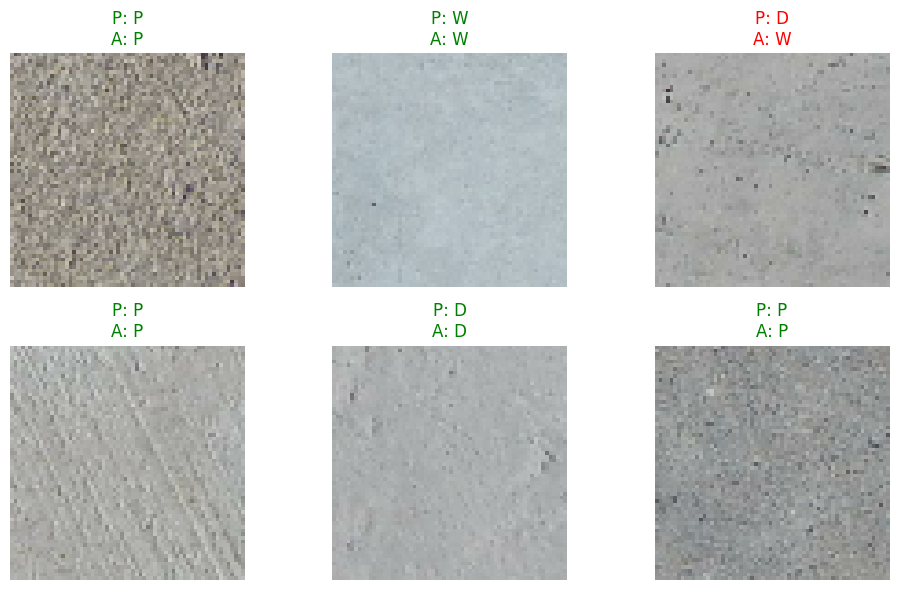

In [16]:
# --- Visualization 2: Classification Results ---
plt.figure(figsize=(10, 6))
# We take one batch from the optimized val_ds
for images, labels in val_ds.take(1):
    predictions = model.predict(images)
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Use the class_names list we saved earlier
        pred_label = class_names[np.argmax(predictions[i])]
        true_label = class_names[labels[i]]
        
        color = 'green' if pred_label == true_label else 'red'
        plt.title(f"P: {pred_label}\nA: {true_label}", color=color)
        plt.axis("off")
plt.tight_layout()
plt.show()

## Conclusion 

The CNN model successfully learned to distinguish between cracked and uncracked concrete surfaces using the SDNET2018 dataset. By utilizing multiple convolutional and pooling layers, the network effectively extracted spatial features such as line edges and surface textures indicative of structural damage. The visualization of training curves indicates the model's convergence, while the sample classification plots confirm its practical utility in identifying defects. For further improvement, implementing Data Augmentation or using a Pre-trained Transfer Learning model (like MobileNetV2) could enhance robustness against varying lighting conditions found in real-world infrastructure inspections.


By implementing hardware-aware configurations and the TensorFlow Data Prefetching (AUTOTUNE) API, this code ensures robust execution across various computing environments. The model leverages spatial feature extraction to identify concrete fatigue, while the use of Dropout layers and Memory Growth prevents common pitfalls like overfitting and VRAM exhaustion. This setup provides a scalable foundation for deploying automated structural health monitoring systems on either local workstations or cloud-based GPU clusters.